### Markovian embedding of finite-size noise $\eta$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpmath as mp
from scipy.signal import welch

def OUCoefs(X0,X1,Y1,Y2):
    
    Beta=1
    a = np.sqrt(Y1/(4*Y2) + 1/(2*np.sqrt(Y2)));
    W = np.sqrt(X0 + (Beta**2)) - Beta;
    a2 = (a*X1 + W*np.sqrt(X1 + 2*W*Beta*np.sqrt(Y2)+ 4*(a**2)*Y2*(Beta**2)) )/(X1 + 2*Beta*np.sqrt(Y2)*W)
    a1 = (a**2 - 1/np.sqrt(Y2))/a2
    b = W/(np.sqrt(Y2)*(a - a2))
    return Beta,a,a1,a2,b

R=lambda s,Xr,Xt: (mp.exp((Xr**2)/2 )*mp.pcfd(-s,-mp.sqrt(2)*Xr))/(mp.exp((Xt**2)/2 )*mp.pcfd(-s,-mp.sqrt(2)*Xt))

def ComputeCV(Xr,Xt):
    dRds=mp.diff(R,(0,Xr,Xt),(1,0,0)) 
    d2Rds2= mp.diff(R,(0,Xr,Xt),(2,0,0))
    CV=np.array( mp.sqrt(d2Rds2-dRds**2)/(-dRds),dtype=float)
    Nu0=-1/(dRds*Tau)
    return CV,Nu0

T=lambda s,Nu0,Xt,Xr,Tau: (R(s*Tau,Xr,Xt)/(1-R(s*Tau,Xr,Xt))) -(Nu0/s)

# Analytic expression of the finite size noise as a function of the Laplace transform of the ISI
SEta=lambda Om,Xr,Xt,Nu0,Tau: 1- np.abs(T(1j*Om,Nu0,Xt,Xr,Tau)/(1+T(1j*Om,Nu0,Xt,Xr,Tau)) )**2
SEta=np.vectorize(SEta,otypes=[float])

Model1D=lambda Om,T,b: 1 +(2*b+b**2)/(1+T * (Om**2))
Model2D=lambda Om,X0,X1,Y1,Y2: 1+ (X0 +X1*(Om**2))/(1+Y1*(Om**2) + Y2*(Om**4) )


#Routine for Markovian embedding parameters:
def EMparams(Mu,Sig,Nu0,Vt,Vr,Tau,DoPlot=False):

    CV,Nu0=ComputeCV((Vr-Mu)/Sig,(Vt-Mu)/Sig)
    S0=(4*CV**2/(1+CV**2)**2)
    X0=S0-1
    S1=0.15*(1-S0)+S0
    S2=0.5*(1-S0)+S0
    S3=(1-S0)+S0
    Farr=np.linspace(1,1000,850)
    Sarr=SEta(2*np.pi*Farr,(Vr-Mu)/Sig,(Vt-Mu)/Sig,Nu0,Tau)
    O1=2*np.pi*Farr[np.abs(Sarr-S1).argmin()]
    O2=2*np.pi*Farr[np.abs(Sarr-S2).argmin()]
    O3=2*np.pi*Farr[np.abs(Sarr-S3).argmin()]
    Oms=np.array([O1,O2,O3])
    S=SEta(Oms,(Vr-Mu)/Sig,(Vt-Mu)/Sig,Nu0,Tau)

    Gamma=S-1
    A=np.array([[Oms[0]**2,-Gamma[0]*(Oms[0]**2),-Gamma[0]*(Oms[0]**4)],
                [Oms[1]**2,-Gamma[1]*(Oms[1]**2),-Gamma[1]*(Oms[1]**4)],
                [Oms[2]**2,-Gamma[2]*(Oms[2]**2),-Gamma[2]*(Oms[2]**4)]])

    Z=np.dot(np.linalg.inv(A),Gamma-X0) 
    X1,Y1,Y2=Z[0],Z[1],Z[2]
    try: Beta,a,a1,a2,b=OUCoefs(X0,X1,Y1,Y2)
    except:
        print('Failed in OU-Params')
        Beta,a,a1,a2,b=np.nan,np.nan,np.nan,np.nan,np.nan
    if DoPlot:
        plt.loglog(Farr,Sarr)
        plt.loglog(Farr,Model2D(2*np.pi*Farr,X0,X1,Y1,Y2))
        plt.show()
        
    return Beta,a,a1,a2,b  

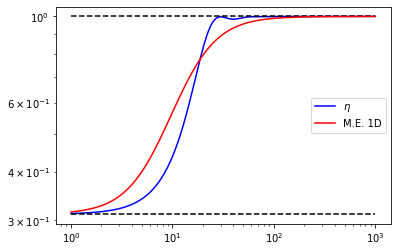

In [2]:
Vt,Vr,Tau=20,0,0.02


F=np.logspace(0,3,300)
Mu=21
Sig=2.5
CV,Nu0=ComputeCV((Vr-Mu)/Sig,(Vt-Mu)/Sig)

S=SEta(2*np.pi*F,(Vr-Mu)/Sig,(Vt-Mu)/Sig,Nu0,Tau)
plt.loglog(F,S,'-b',label=r'$\eta$')
plt.plot([F[0],F[-1]],[1,1],'--k')
Z=4*CV**2/(1+CV**2)**2
plt.plot([F[0],F[-1]],[Z,Z],'--k')
#1D model test
b=np.sqrt(Z)-1
TauA=0.00015
plt.plot(F,Model1D(F*2*np.pi,TauA,b),'-r',label='M.E. 1D')
plt.legend()

In [3]:

#Testing S.D.E
Beta,a,a1,a2,b =EMparams(Mu,Sig,Nu0,Vt,Vr,Tau,DoPlot=False)

def IntegrateEta(Z,dt,u1,u2,Beta,a,a1,a2,b):
    u1n=u1 +dt*(-a*u1-a1*u2) + b*np.sqrt(dt)*Z
    u2n=u2 +dt*(-a2*u1-a*u2)
    Eta=Beta*Z/np.sqrt(dt) +u1n+u2n
    return Eta,u1n,u2n

Life=60
dt=0.01/1000
Step=int(Life/dt)
Eta=np.zeros(Step)
u1,u2=0,0
for i in range(Step):
    Z=np.random.randn()
    Eta[i],u1,u2=IntegrateEta(Z,dt,u1,u2,Beta,a,a1,a2,b)
    


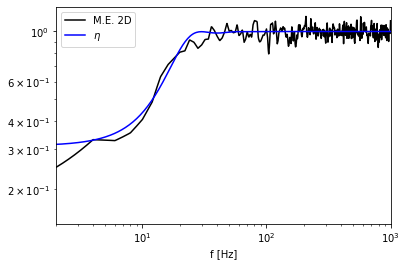

In [7]:
fs=1/dt
Ind=int(1/dt)
nFreq=50000
f, Pxx_den = welch(Eta[Ind:], fs, nperseg=nFreq,return_onesided=True)
F1=np.logspace(0,3,1000)
S1=np.interp(F1,f,Pxx_den/2)   
plt.loglog(F1,S1,'-k',label='M.E. 2D')
plt.loglog(F,S,'-b',label=r'$\eta$')
plt.xlim(2,1000)
plt.xlabel("f [Hz]")
plt.legend();